In [2]:
import numpy as np
from matplotlib import pyplot as plt

from wpg.optical_elements import Drift, Mirror_plane_2d, Aperture
from wpg.wpg_uti_oe import propagation_parameters
from wpg.source import sase_pulse
from midsim.source import analytical_pulse_divergence, analytical_pulse_width
from midsim.utils import set_fontsize_for_all_elements
from wpg.beamline import Beamline

In [3]:
#M1 = Mirror_plane_2d('x', theta = 1.2e-03, length = 848.7e-03,range_xy=19.2e-3,filename = '/home/guestt/midsim/midsim/data/SA2_M1_HeightErr.txt', nx = 1024)
#M2 = Mirror_plane_2d('x', theta = 1.2e-03, length = 848.7e-03,range_xy=19.2e-3,filename = '/home/guestt/midsim/midsim/data/SA2_M1_HeightErr.txt', nx = 1024)


In [4]:
from matplotlib.colors import LogNorm, Normalize

def plot_wfr(wfr, logscale=False, title = None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    intensity = wfr.get_intensity().sum(-1)
    
    if logscale:
        norm = LogNorm(vmin=intensity[intensity > 0].min(), vmax=intensity.max())
    else:
        norm = Normalize(vmin=intensity.min(), vmax=intensity.max())
    
    try:
        extent =  [a*1e3 for a in [wfr.xMin, wfr.xMax, wfr.yMin, wfr.yMax]]
        
    except(TypeError):
        extent =  [a*1e3 for a in [wfr.qxMin, wfr.qxMax, wfr.qyMin, wfr.qyMax]]

    im = ax.imshow(intensity,
                   extent=extent,
                   cmap='afmhot',
                   norm=norm)
    
    ax.set_xlabel('x (mm)')
    ax.set_xlabel('y (mm)')
    
    if title:
        ax.set_title(title)
    fig.colorbar(im, ax=ax, orientation='vertical')


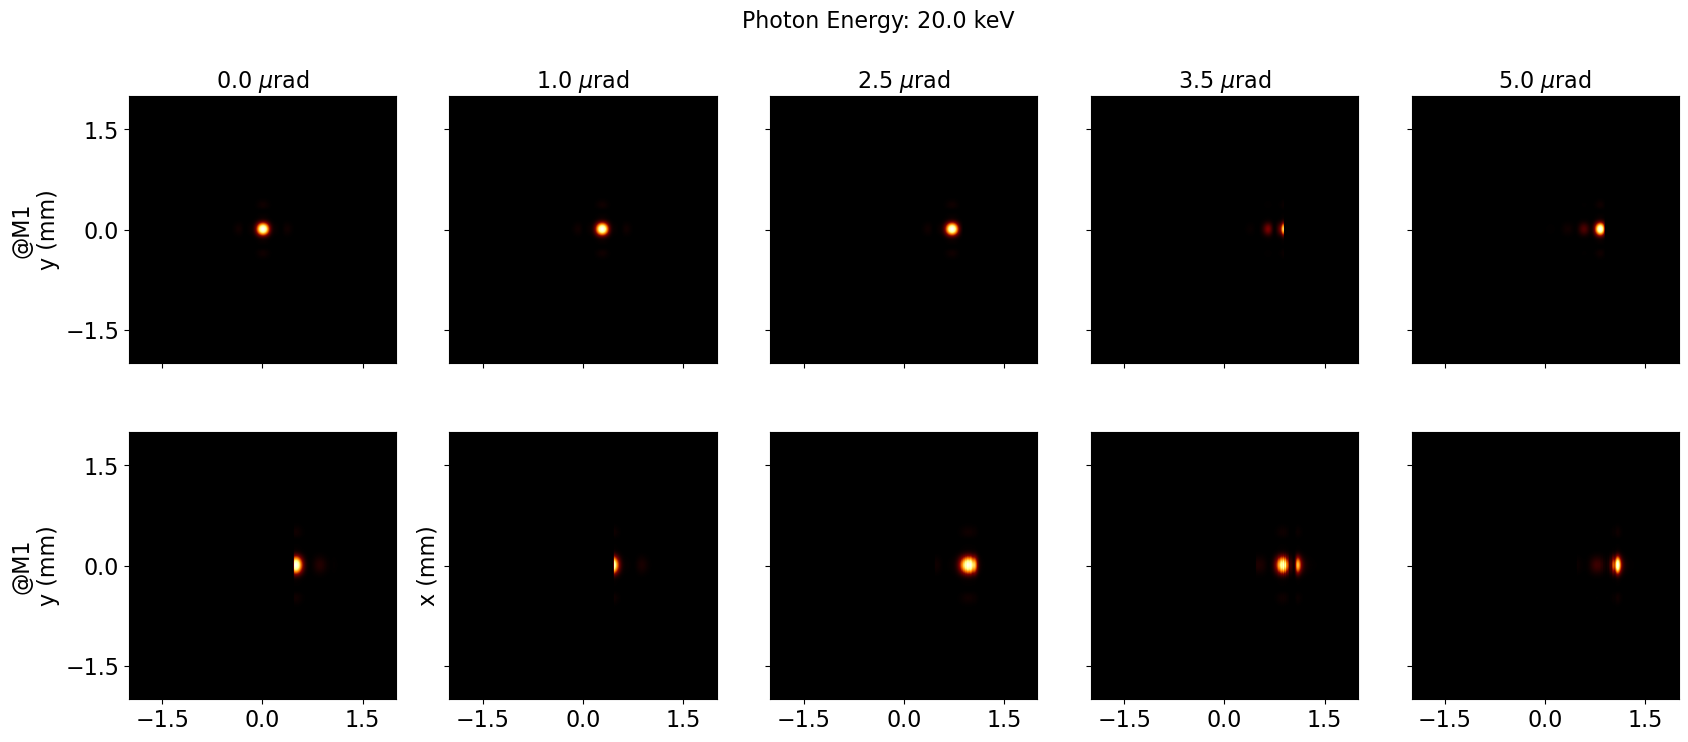

In [72]:
x = y = np.linspace(-450e-06, 450e-06, 1024)
t = np.linspace(-50e-15, 50e-15, 2)
L = 0.8
theta_y = 0
photon_energy = 20e03
M3_pos = 1e-03
theta_x = np.array([0, 1e-06, 2.5e-06,3.5e-06, 5.0e-06])

wavefronts = sase_pulse(x=x,
                        y=y,
                        t=t,
                        photon_energy=photon_energy,
                        pulse_energy=1e-03,
                        pulse_duration=25e-15,
                        bandwidth=1e-12,
                        sigma=analytical_pulse_width(photon_energy),
                        div=analytical_pulse_divergence(photon_energy),
                        x0=0.0,
                        y0=0.0,
                        t0=0.0,
                        theta_x= theta_x,
                        theta_y=0.0,
                        domain='freq',
                        polarization = 'horizontal')


if photon_energy == 12e3:
    theta_12 = 2.2e-03
elif photon_energy == 17e03:
    theta_12 = 1.8e-03
elif photon_energy >= 20e03:
    theta_12 = 2.2e-03#1.3e-03

M3_A = (L)*np.sin(1.35e-03)

M1 = M2 = Aperture('r','a',Dx = (L)*np.sin(theta_12),Dy = 20e-03)
M3 = Aperture('r','a',Dx = M3_A,Dy = 20e-03, x = M3_pos)

s2M1 = Beamline()
s2M1.append(Drift(290), propagation_parameters(5,1,5,1,mode = 'fresnel'))
s2M1.append(M1, propagation_parameters(1,1,1,1, mode = 'fresnel'))

M12M3 = Beamline()
M12M3.append(Drift(11), propagation_parameters(1,1,1,1,mode = 'fresnel'))
M12M3.append(M2, propagation_parameters(1,1,1,1, mode = 'fresnel'))
M12M3.append(Drift(90), propagation_parameters(1,1,1,1,mode = 'fresnel'))
M12M3.append(M3, propagation_parameters(1,1,1,1, mode = 'fresnel'))


fig, ax = plt.subplots(2,5,figsize = (20,8), sharex = True, sharey = True)
fig.suptitle(f'Photon Energy: {photon_energy/1e3} keV')

for itr, wfr in enumerate(wavefronts):


    #i0 = wfr.get_intensity().sum()
    s2M1.propagate(wfr)

    extent =  [a*1e3 for a in [wfr.xMin, wfr.xMax, wfr.yMin, wfr.yMax]]
    
    ax[0,itr].imshow(wfr.get_intensity().sum(-1), cmap = 'afmhot', extent = extent)
    ax[0,itr].set_title("{} $\mu$rad".format(theta_x[itr]*1e6))

    if itr == 0:
        ax[0,0].set_ylabel("@M1\ny (mm)")
        ax[1,0].set_ylabel("@M1\ny (mm)")

    M12M3.propagate(wfr)
    #iF = wfr.get_intensity().sum()


    ax[1,itr].imshow(wfr.get_intensity().sum(-1), cmap = 'afmhot', extent = extent)
    #ax[1,itr].set_title("I/I0 = {:.2f}%".format(iF/i0 * 100))    

    ax[1,1].set_ylabel("x (mm)")
    

for a in ax.flatten():
    a.set_xlim(-2.0,2.0)
    a.set_ylim(-2.0,2.0)
    a.set_yticks([-1.5,0,1.5])
    a.set_xticks([-1.5,0,1.5])

set_fontsize_for_all_elements(fig, 16)
plt.show()




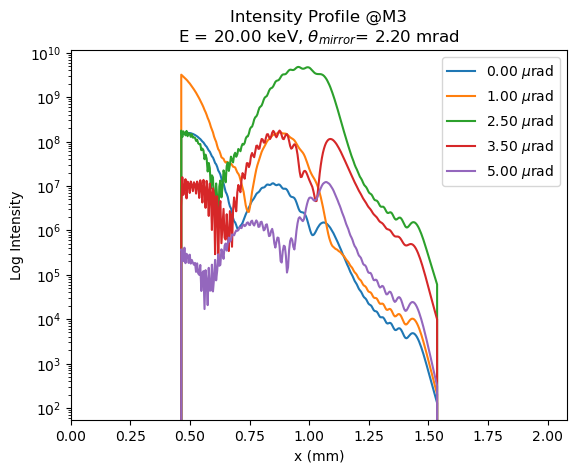

In [73]:
fig, ax = plt.subplots()
ax.set_title("Intensity Profile @M3\nE = {:.2f} keV".format(photon_energy/1e3) + r", $\theta_{mirror}$" +  "= {:.2f} mrad".format(theta_12*1e3))
ax.set_xlabel("x (mm)")
ax.set_ylabel("Log Intensity")
ax.set_xlim(0, (M3_pos + M3_A)*1e3)

for itr, wfr in enumerate(wavefronts):
    ax.semilogy(wfr.get_axis('x')*1e3, wfr.get_profile('x')*1e3, label = '{:.2f} $\mu$rad'.format(theta_x[itr]*1e6))
    ax.legend()

